# 01 Data Analysis & Preprocessing

This notebook demonstrates the data analysis and preprocessing pipeline for the fraud detection project.

## 1. Setup and Imports

In [37]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))  # Add project root to path for src imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from IPython.display import display
try:
    from src.data_preprocessing import main
except ModuleNotFoundError as e:
    print('Could not import src.data_preprocessing. Ensure you are running from the correct directory and src exists.')
    raise e

%matplotlib inline

## 2. Load Configuration

In [38]:
import yaml
config_path = '../config.yaml'
if not os.path.exists(config_path):
    raise FileNotFoundError(f'Config file not found at {config_path}. Please create it as described above.')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
if not config or 'data' not in config or 'raw' not in config['data'] or 'processed' not in config['data']:
    raise ValueError('Config file is missing required keys. Please ensure it matches the documented structure.')
config

{'data': {'raw': {'fraud': '../data/raw/Fraud_Data.csv',
   'ip_country': '../data/raw/IpAddress_to_Country.csv',
   'creditcard': '../data/raw/creditcard.csv'},
  'processed': {'fraud': '../data/processed/fraud_processed.csv',
   'creditcard': '../data/processed/creditcard_processed.csv',
   'fraud_train_smote': '../data/processed/fraud_train_smote.csv',
   'fraud_train_labels_smote': '../data/processed/fraud_train_labels_smote.csv',
   'fraud_test': '../data/processed/fraud_test.csv',
   'fraud_test_labels': '../data/processed/fraud_test_labels.csv',
   'credit_train_smote': '../data/processed/credit_train_smote.csv',
   'credit_train_labels_smote': '../data/processed/credit_train_labels_smote.csv',
   'credit_test': '../data/processed/credit_test.csv',
   'credit_test_labels': '../data/processed/credit_test_labels.csv'}},
 'model': {'train_test_split': {'test_size': 0.2, 'random_state': 42},
  'smote': {'random_state': 42}}}

## 3. Raw Data Overview

In [39]:
# Load raw datasets
fraud_raw = pd.read_csv(config['data']['raw']['fraud'])
ip_raw = pd.read_csv(config['data']['raw']['ip_country'])
credit_raw = pd.read_csv(config['data']['raw']['creditcard'])

print('Fraud Data:')
display(fraud_raw.head())
print(fraud_raw.info())
print(fraud_raw.isnull().sum())

print('IP to Country Data:')
display(ip_raw.head())
print(ip_raw.info())
print(ip_raw.isnull().sum())

print('Credit Card Data:')
display(credit_raw.head())
print(credit_raw.info())
print(credit_raw.isnull().sum())

Fraud Data:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dty

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Credit Card Data:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 4. Run Preprocessing Pipeline

In [40]:
# This will preprocess data and save processed files
result = main(config)
print('Preprocessing complete!')

2025-07-18 12:05:04,039 - INFO - Checking missing values in fraud_data
d:\Projects\Python\fraud-detection\fraud_detection_project\src\data_preprocessing.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
2025-07-18 12:05:04,075 - INFO - Imputed source with mode: SEO
2025-07-18 12:05:04,089 - INFO - Imputed browser with mode: Chrome
2025-07-18 12:05:04,101 - INFO - Imputed sex with mode: M
d:\Projects\Python\fraud-detection\fraud_detection_project\src\data_preprocessing.py:25: F


Missing Values in fraud_data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Missing Values in ip_country:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

Missing Values in creditcard:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


2025-07-18 12:05:04,297 - INFO - Removed 0 duplicates from fraud_data. New shape: (151112, 11)
2025-07-18 12:05:04,404 - ERROR - Error cleaning data: cannot safely cast non-equivalent object to int64
2025-07-18 12:05:04,430 - INFO - Removed 0 duplicates from ip_country. New shape: (138846, 3)
2025-07-18 12:05:05,071 - INFO - Removed 1081 duplicates from creditcard. New shape: (283726, 31)
2025-07-18 12:05:05,137 - INFO - Merged IP to Country. Country Distribution:
country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
                     ...  
Myanmar                  1
South Sudan              1
Guadeloupe               1
Cape Verde               1
Nauru                    1
Name: count, Length: 181, dtype: int64
d:\Projects\Python\fraud-detection\fraud_detection_project\src\data_preprocessing.py:98: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assi

Preprocessing complete!


## 5. Quick EDA on Processed Data

In [41]:
fraud = pd.read_csv(config['data']['processed']['fraud'])
credit = pd.read_csv(config['data']['processed']['creditcard'])

print('Processed Fraud Data:')
display(fraud.head())
print(fraud.describe())
print(fraud['class'].value_counts())

print('Processed Credit Card Data:')
display(credit.head())
print(credit.describe())
print(credit['Class'].value_counts())

Processed Fraud Data:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,lower_bound_ip_address,upper_bound_ip_address,country,transaction_count_user,transaction_count_device,time_diff,avg_time_between_txn,hour_of_day,day_of_week,time_since_signup
0,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,8.802175e+08,...,8.724152e+08,8.891924e+08,United States,1,1,NaN,0.0,10,5,990.273333
1,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2.785906e+09,...,2.785542e+09,2.786066e+09,Switzerland,1,1,NaN,0.0,21,5,2788.855278
2,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,3.560567e+08,...,3.523215e+08,3.690988e+08,United States,1,1,NaN,0.0,11,3,1852.000278
3,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2.985180e+09,...,2.985034e+09,2.985296e+09,Mexico,1,1,NaN,0.0,20,2,1286.523611
4,16,2015-02-03 13:48:23,2015-03-12 12:46:23,9,FROZWSSWOHZBE,Direct,IE,M,32,5.783125e+08,...,5.704253e+08,5.872026e+08,United States,1,1,NaN,0.0,12,3,886.966667


             user_id  purchase_value            age    ip_address  \
count  129146.000000   129146.000000  129146.000000  1.291460e+05   
mean   200130.920416       36.932456      33.128413  1.892795e+09   
std    115358.923526       18.317798       8.615297  1.085207e+09   
min         2.000000        9.000000      18.000000  1.677886e+07   
25%    100603.250000       22.000000      27.000000  9.561635e+08   
50%    199971.500000       35.000000      33.000000  1.899710e+09   
75%    299994.750000       49.000000      39.000000  2.832125e+09   
max    400000.000000      154.000000      76.000000  3.758053e+09   

               class  lower_bound_ip_address  upper_bound_ip_address  \
count  129146.000000            1.291460e+05            1.291460e+05   
mean        0.094993            1.890950e+09            1.894646e+09   
std         0.293207            1.086802e+09            1.083635e+09   
min         0.000000            1.677824e+07            1.677926e+07   
25%         0.0000

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.850134      -0.6898

## 6. Show Processed Data Output Paths

In [42]:
for k, v in config['data']['processed'].items():
    print(f'{k}: {v}')

fraud: ../data/processed/fraud_processed.csv
creditcard: ../data/processed/creditcard_processed.csv
fraud_train_smote: ../data/processed/fraud_train_smote.csv
fraud_train_labels_smote: ../data/processed/fraud_train_labels_smote.csv
fraud_test: ../data/processed/fraud_test.csv
fraud_test_labels: ../data/processed/fraud_test_labels.csv
credit_train_smote: ../data/processed/credit_train_smote.csv
credit_train_labels_smote: ../data/processed/credit_train_labels_smote.csv
credit_test: ../data/processed/credit_test.csv
credit_test_labels: ../data/processed/credit_test_labels.csv


## 7. Visualizations: Class Balance & Feature Distributions

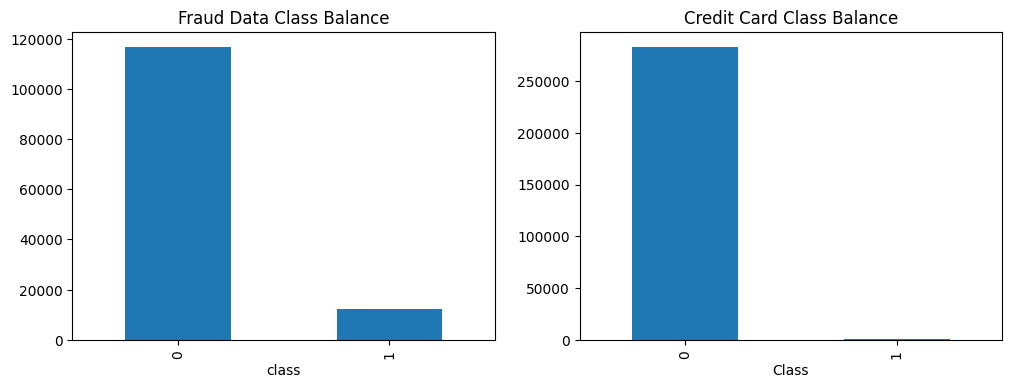

In [43]:
# Class balance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fraud['class'].value_counts().plot(kind='bar', ax=axes[0], title='Fraud Data Class Balance')
credit['Class'].value_counts().plot(kind='bar', ax=axes[1], title='Credit Card Class Balance')
plt.show()

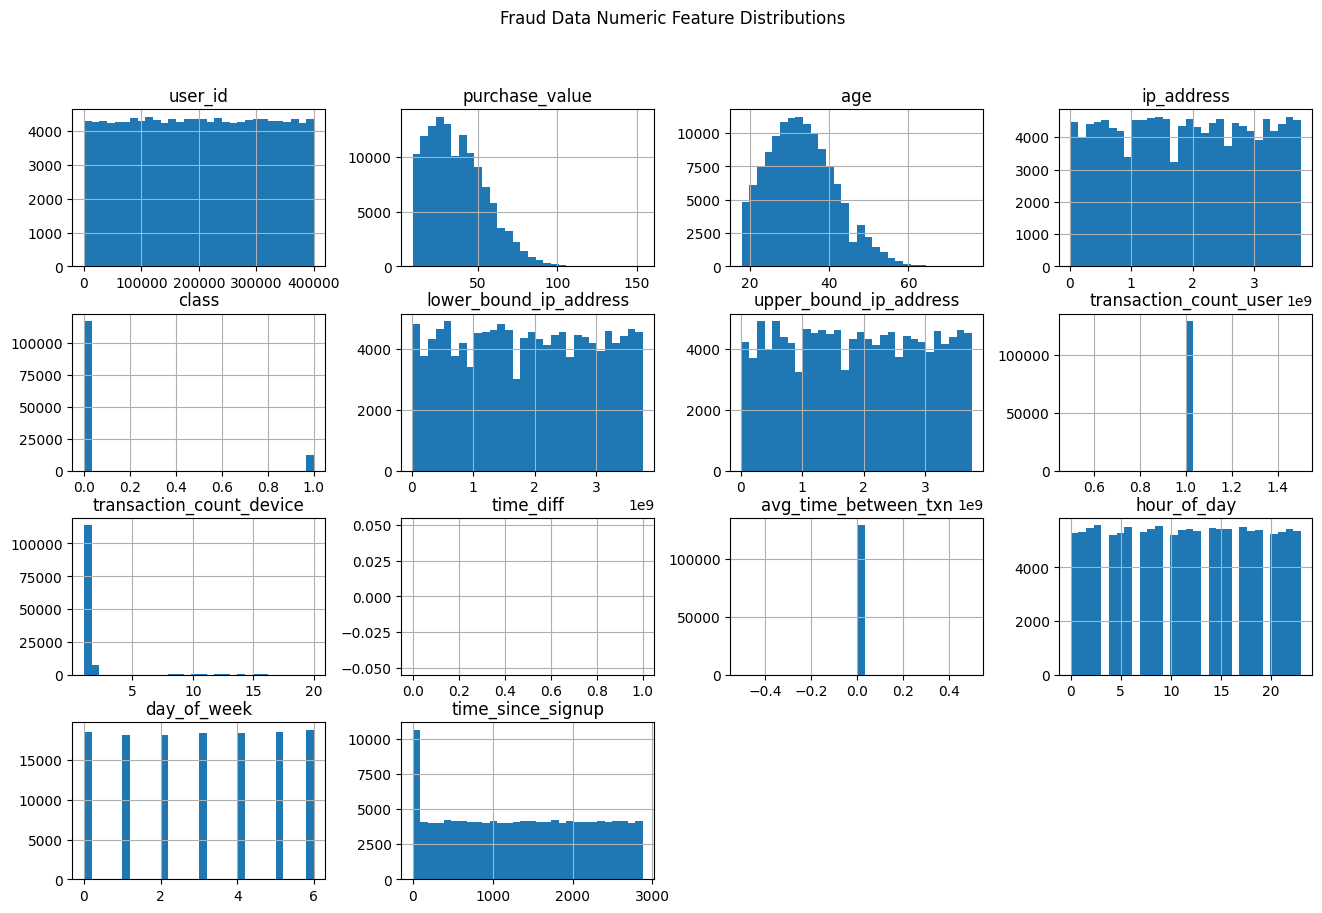

In [44]:
# Feature distributions (histograms for numeric features)
num_cols_fraud = fraud.select_dtypes(include=np.number).columns
fraud[num_cols_fraud].hist(figsize=(16, 10), bins=30)
plt.suptitle('Fraud Data Numeric Feature Distributions')
plt.show()

2025-07-18 12:06:47,699 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-18 12:06:47,759 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


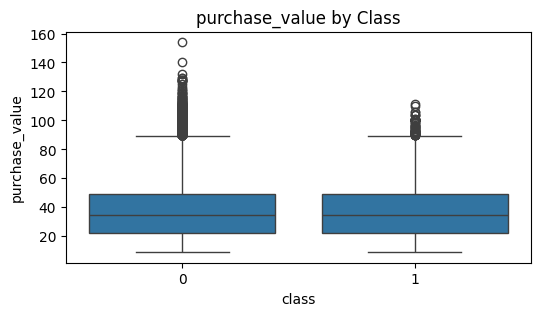

2025-07-18 12:06:47,903 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-18 12:06:47,959 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


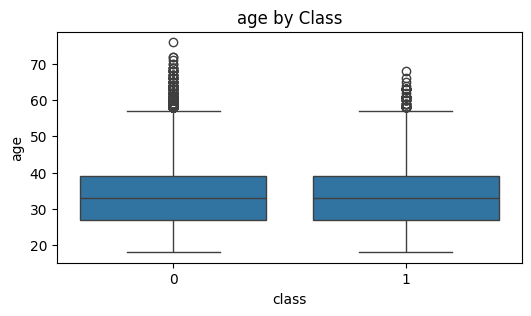

2025-07-18 12:06:48,109 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-18 12:06:48,164 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


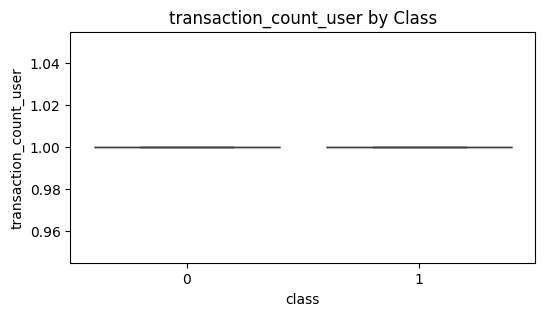

2025-07-18 12:06:48,308 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-18 12:06:48,376 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


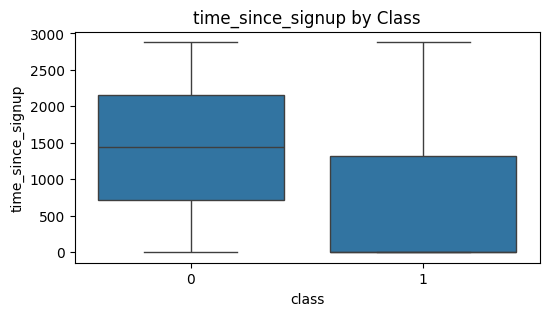

In [45]:
# Boxplots for selected features
selected = [col for col in ['purchase_value', 'age', 'transaction_count_user', 'time_since_signup'] if col in fraud.columns]
for col in selected:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='class', y=col, data=fraud)
    plt.title(f'{col} by Class')
    plt.show()